In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
def oracle(qc, nodes_qubits, edge_anc):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0] ], nodes_qubits[edges[i][1] ], edge_anc[0]], edge_anc[1])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        
def reverse_oracle(qc, nodes_qubits, edge_anc):
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1])
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])

In [4]:
def get_possible_claw_vertices(n_nodes, edges):
    claw_vertex_dict = {str(num): 0 for num in range(n_nodes)}
    for edge in edges:
        claw_vertex_dict[str(edge[0])] += 1
        claw_vertex_dict[str(edge[1])] += 1
    print(claw_vertex_dict)
    claw_vertices = []
    for i, val in enumerate(claw_vertex_dict.values()):
        b = ['0']*n_nodes
        if val == 3:
            b[i] = '1'
            for edge in edges:
                if edge[0] == i:
                    b[edge[1]] = '1'
                elif edge[1] == i:
                    b[edge[0]] = '1'
            # join in reverse order
            claw_vertices.append(''.join(b[::-1]))
    print(claw_vertices)             
    return claw_vertices

In [5]:
# PROBLEMS:
n_nodes = 4
edges = [(0, 1), (0, 2), (1, 2), (2, 3)]

# n_nodes = 4
# edges = [(0, 2), (1, 2), (2, 3)]

# n_nodes = 5
# edges = [(0, 2), (1, 2), (2, 3), (3, 4)]

# n_nodes = 5
# edges = [(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)]

# n_nodes = 6
# edges = [(1, 2), (0, 2), (2, 3), (1, 4), (0, 4), (4, 5), (1, 3)]

# n_nodes = 4
# edges = [(0, 1), (1, 2), (2, 3)]

# 7
n_nodes = 6
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 3), (0, 4)]

# 8 
n_nodes = 4
edges = [(0, 1), (1, 2), (2, 3)]

# 9
n_nodes = 7
edges = [(0, 1), (1, 2), (1, 4), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6)]

possible_claw_vertices = get_possible_claw_vertices(n_nodes, edges)

{'0': 1, '1': 3, '2': 1, '3': 3, '4': 3, '5': 3, '6': 2}
['0010111', '1111000', '0111010', '1111000']


In [21]:
def grover():
    node_qubits = QuantumRegister(n_nodes, name='n')
    vertex_flag = QuantumRegister(1, name='is_four_ones')
    e_qubits = QuantumRegister(2, name='e')
    flag_qubit = QuantumRegister(1, name="flag")
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    qc = QuantumCircuit(node_qubits, vertex_flag, e_qubits, flag_qubit, class_bits)
    # Initialize qunatum flag qubits in |-> state. i.e. qc.initialize([1, -1]/np.sqrt(2), flag_qubit)
    qc.x(flag_qubit)
    qc.h(flag_qubit)
    
    # Initializing i/p qubits in superposition
    qc.h(node_qubits)
    qc.barrier()

    num_iterations = n_nodes - 1 # TODO: how to find a good number of iterations?
    for i in range(num_iterations):
        # 1
        for claw_vertex in possible_claw_vertices:
            qc.append(MCXGate(n_nodes, ctrl_state=claw_vertex), node_qubits[:] + vertex_flag[:])
        
        # 2
        oracle(qc, node_qubits, e_qubits)

        qc.mct([vertex_flag, e_qubits[0], e_qubits[1]], flag_qubit)    

        # 2 reverse
        reverse_oracle(qc, node_qubits, e_qubits)
        
        # 1 reverse
        for claw_vertex in possible_claw_vertices[::-1]:
            qc.append(MCXGate(n_nodes, ctrl_state=claw_vertex), node_qubits[:] + vertex_flag[:])    

        qc.barrier()
        qc.append(diffuser(n_nodes), node_qubits)
                
    qc.measure(node_qubits,class_bits)
    return qc

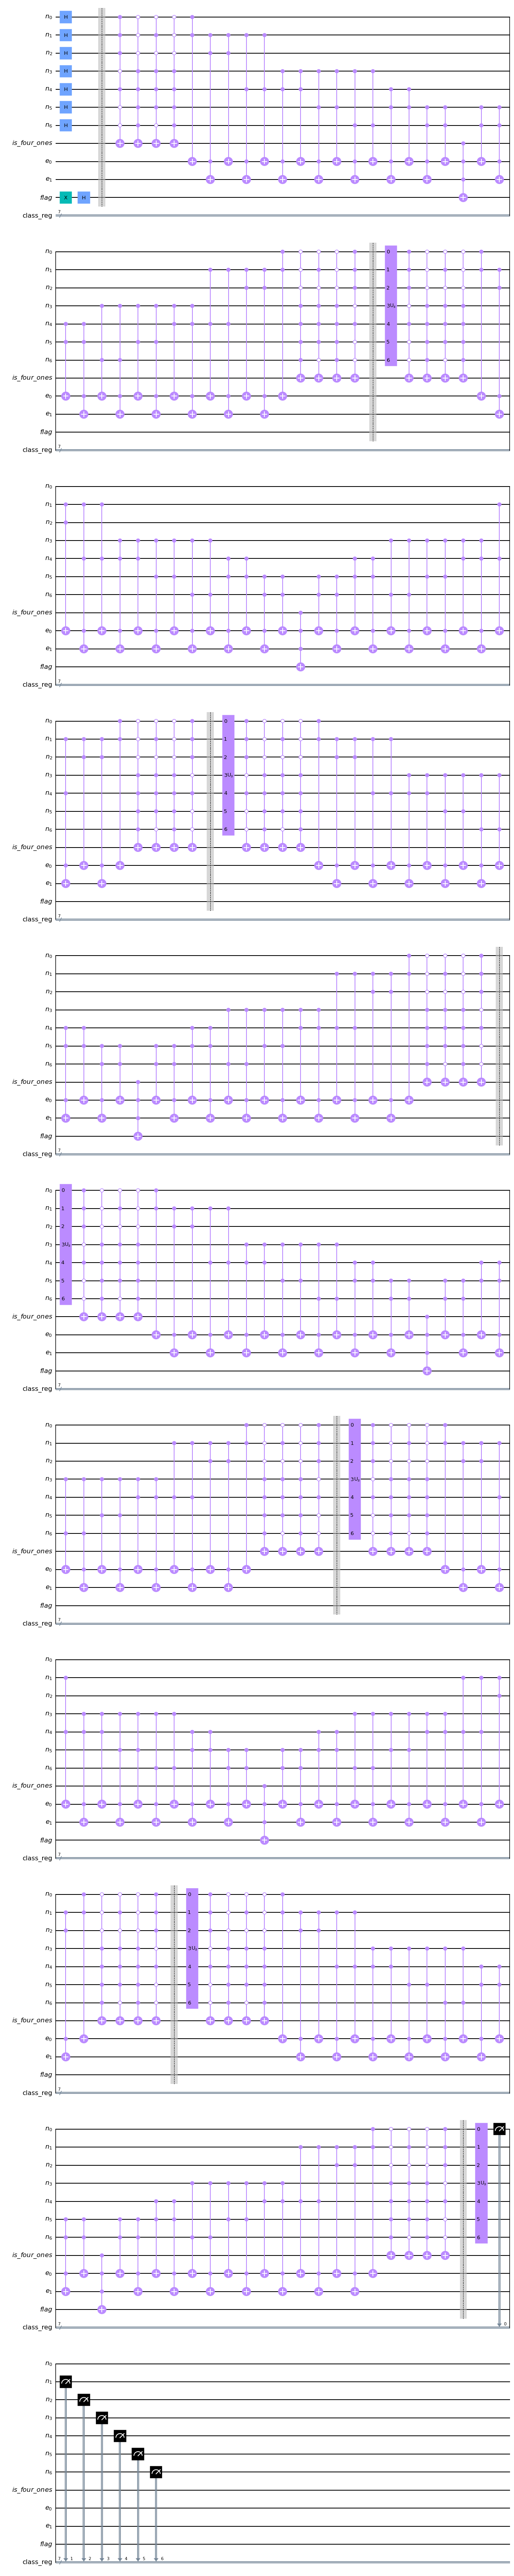

In [22]:
qc = grover()
qc.draw()

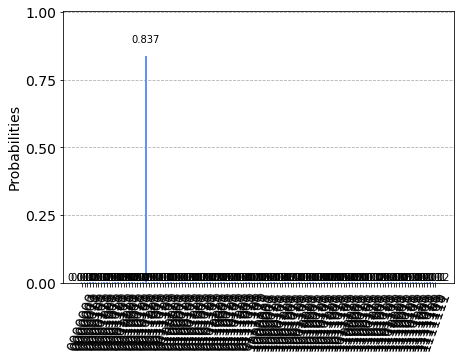

In [23]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=10000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [24]:
counts

{'1010000': 7,
 '0001111': 15,
 '1110110': 11,
 '0001000': 11,
 '0110100': 12,
 '0001110': 14,
 '0110101': 7,
 '1101010': 12,
 '0010101': 12,
 '0110010': 8,
 '0000100': 8,
 '0011110': 11,
 '1110111': 11,
 '0100010': 13,
 '1101101': 9,
 '1000001': 16,
 '0010001': 10,
 '1111010': 5,
 '0001100': 15,
 '0000000': 11,
 '1110100': 9,
 '1011100': 18,
 '1111111': 15,
 '0010010': 22,
 '0101001': 8,
 '0100100': 12,
 '1010101': 13,
 '0010110': 10,
 '1010111': 16,
 '1110101': 13,
 '0111011': 15,
 '0000010': 9,
 '1001111': 9,
 '1000101': 19,
 '0010111': 8370,
 '0100011': 15,
 '1001011': 11,
 '0110110': 14,
 '0011011': 10,
 '0010011': 19,
 '0000101': 15,
 '1101001': 11,
 '0101110': 12,
 '1000111': 16,
 '0100111': 14,
 '0101011': 12,
 '1100100': 13,
 '0010100': 16,
 '0111010': 14,
 '0011000': 16,
 '0111101': 11,
 '0111110': 15,
 '1010100': 16,
 '0011100': 10,
 '0110001': 13,
 '0010000': 21,
 '0000111': 11,
 '1111100': 11,
 '0011101': 9,
 '0111000': 11,
 '0101000': 15,
 '0110011': 15,
 '0111100': 14,
 